### Simplified Solar Angle Calculations

A simplified function to calculate solar angles from timestamps, latitude and longitude, e.g. from a brtdevkit query. </br>
This is an updated version of the old notebook at: https://github.com/BlueRiverTechnology/dl-sandbox/blob/master/notebooks/Calculate%20Solar%20Angle.ipynb

In [104]:
# Query a DataFrame to compute Solar angles
# This cell is only used here to generate the example data

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from brtdevkit.core.db import DBConnector, DatetimeFilter
from warnings import filterwarnings
filterwarnings("ignore")

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

#def get_field():

# Set filters 
filters = {"artifacts.kind": "nrg", 
           "crop_name": {"$in": ['CORN', 'COTTON', 'SOYBEANS']}, 
           "robot_name": {"$in": ["DCM-MANATEE","DCM-OTTER", "DCM-DOLPHIN", "DCM-WALRUS", "DCM-PORPOISE", "DCM-SEAL"]} }

start = dt(2020, 3,1)
end = dt(2020, 4, 1)

df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
df['date_collected'] = pd.to_datetime(df['collected_on'].dt.date)
print(f"Queried {len(df)} images in {elapsed_time:.2f} s.")

Queried 12791 images in 19.16 s.


In [110]:
import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *

# You can instantiate the TimezoneFinder() oject inside the function if needed, but it will slow down the computation about 15%
tf = TimezoneFinderL()

# Remove Bad GPS coordinates, if needed
df =df[df['gps_quality']=='AUTONOMOUS']

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

# apply to brtdevkit DataFrame with 'collected_on', 'latitude' and 'longitude' columns
df['solar_angle'] = df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)

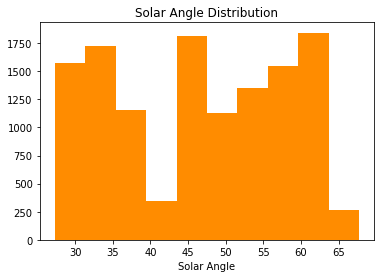

In [106]:
plt.hist(mdf['solar_angle'], color='darkorange')
plt.xlabel('Solar Angle')
plt.title('Solar Angle Distribution')
plt.show()